In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Loading the Data

This notebook aims to train a neural network replicate the denoised version of the carotid MRI image dataset using the iterative B3MD unsupervised algorithm. The goal is for the neural network to be able to sample clean versions of the images much faster than the iterative bm3d procedure

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, clean_img_dir, noisy_img_dir, transform=None, max_images=160):
        self.clean_img_dir = clean_img_dir
        self.noisy_img_dir = noisy_img_dir
        self.transform = transform
        self.max_images = max_images  

        # Load and limit the image names list to the first 'max_images' images
        self.img_names = [f for f in os.listdir(clean_img_dir) if os.path.isfile(os.path.join(clean_img_dir, f))][:self.max_images]

    def __len__(self):
        # The length is now limited to either the total number of images or 'max_images', whichever is smaller
        return min(len(self.img_names), self.max_images)

    def __getitem__(self, idx):
        clean_img_path = os.path.join(self.clean_img_dir, self.img_names[idx])
        noisy_img_path = os.path.join(self.noisy_img_dir, self.img_names[idx])

        clean_image = Image.open(clean_img_path).convert('L')
        noisy_image = Image.open(noisy_img_path).convert('L')

        
        if self.transform:
            clean_image = self.transform(clean_image)
            noisy_image = self.transform(noisy_image)

        return clean_image, noisy_image


In [7]:
# Define your directories
clean_img_dir = r"BM3D_denoised"
noisy_img_dir = r"IMAGES"

# Create the dataset
paired_dataset = PairedImageDataset(clean_img_dir=clean_img_dir, noisy_img_dir=noisy_img_dir, transform=transform)




In [8]:
# Define train-test split ratio
train_ratio = 0.8
test_ratio = 0.2

# Calculate lengths
dataset_size = len(paired_dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Randomly split the dataset
train_dataset, test_dataset = random_split(paired_dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example: Iterate through the train DataLoader and use the paired images
print("Train DataLoader:")
for i, (clean_images, noisy_images) in enumerate(train_dataloader):
    print(f'Batch {i+1}, Clean Shape: {clean_images.shape}, Noisy Shape: {noisy_images.shape}')
    # Here you can use the clean_images and noisy_images tensor batches for your training or evaluation

# Example: Iterate through the test DataLoader and use the paired images
print("Test DataLoader:")
for i, (clean_images, noisy_images) in enumerate(test_dataloader):
    print(f'Batch {i+1}, Clean Shape: {clean_images.shape}, Noisy Shape: {noisy_images.shape}')
    # Here you can use the clean_images and noisy_images tensor batches for your testing or evaluation

Train DataLoader:
Batch 1, Clean Shape: torch.Size([32, 1, 256, 256]), Noisy Shape: torch.Size([32, 1, 256, 256])
Batch 2, Clean Shape: torch.Size([32, 1, 256, 256]), Noisy Shape: torch.Size([32, 1, 256, 256])
Batch 3, Clean Shape: torch.Size([32, 1, 256, 256]), Noisy Shape: torch.Size([32, 1, 256, 256])
Batch 4, Clean Shape: torch.Size([32, 1, 256, 256]), Noisy Shape: torch.Size([32, 1, 256, 256])
Test DataLoader:
Batch 1, Clean Shape: torch.Size([32, 1, 256, 256]), Noisy Shape: torch.Size([32, 1, 256, 256])


## Training the UNET with diffusion

In [9]:
class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [10]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, time_embedding_size=10):
        super(UNet, self).__init__()
        self.n_channels = n_channels + time_embedding_size
        self.n_classes = n_classes
        self.time_embedding_size = time_embedding_size
        
        # Embedding for the time step
        self.time_embedding = nn.Linear(1, time_embedding_size)
        
        # Downsampling Path
        self.inc = DoubleConv(self.n_channels, 32)
        self.down1 = DoubleConv(32, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 256)
        
        # Upsampling Path
        self.up1 = DoubleConv(512, 128)
        self.up2 = DoubleConv(256, 64)
        self.up3 = DoubleConv(128, 32)
        self.up4 = DoubleConv(64, 32)
        
        # Final Convolution
        self.outc = nn.Conv2d(32, n_classes, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Embed the time step
        t = self.time_embedding(t.view(-1, 1))  # t needs to be shaped as (batch_size, 1)
        t = t.view(-1, self.time_embedding_size, 1, 1)  # Reshape to (batch_size, time_embedding_size, 1, 1)

        # Expand t to match the batch size and spatial dimensions of x
        t = t.expand(x.size(0), -1, x.size(2), x.size(3))  # Expand t to match x's batch size, height, and width

        # Concatenate the time embedding to the input
        x = torch.cat([x, t], dim=1)  # Concatenate along the channel dimension
        # Existing U-Net forward path
        x1 = self.inc(x)
        x2 = F.max_pool2d(self.down1(x1), 2)
        x3 = F.max_pool2d(self.down2(x2), 2)
        x4 = F.max_pool2d(self.down3(x3), 2)
        x5 = F.max_pool2d(self.down4(x4), 2)
        
        x = F.interpolate(x5, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x4], dim=1)
        x = F.interpolate(self.up1(x), scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)
        x = F.interpolate(self.up2(x), scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)
        x = F.interpolate(self.up3(x), scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        logits = self.outc(self.up4(x))
        
        return logits

## diffusion conditioned training loop

In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Example values for num_epochs and range of T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)



Training with T=5
Epoch 1/30, Loss: 0.1396
Best model saved with training loss: 0.1396
Epoch 2/30, Loss: 0.0066
Best model saved with training loss: 0.0066
Epoch 3/30, Loss: 0.0036
Best model saved with training loss: 0.0036
Epoch 4/30, Loss: 0.0027
Best model saved with training loss: 0.0027
Epoch 5/30, Loss: 0.0024
Best model saved with training loss: 0.0024
Epoch 6/30, Loss: 0.0021
Best model saved with training loss: 0.0021
Epoch 7/30, Loss: 0.0021
Best model saved with training loss: 0.0021
Epoch 8/30, Loss: 0.0017
Best model saved with training loss: 0.0017
Epoch 9/30, Loss: 0.0016
Best model saved with training loss: 0.0016
Epoch 10/30, Loss: 0.0019
Epoch 11/30, Loss: 0.0024
Epoch 12/30, Loss: 0.0015
Best model saved with training loss: 0.0015
Epoch 13/30, Loss: 0.0015
Best model saved with training loss: 0.0015
Epoch 14/30, Loss: 0.0015
Epoch 15/30, Loss: 0.0016
Epoch 16/30, Loss: 0.0012
Best model saved with training loss: 0.0012
Epoch 17/30, Loss: 0.0013
Epoch 18/30, Loss: 0.

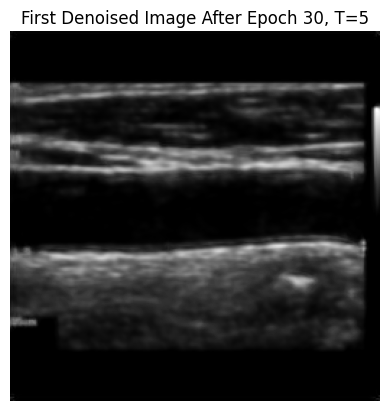

Best model saved at: trained_models\best_model_T_5.pth with training loss: 0.0009


In [122]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt



# Example values for num_epochs and range of T
num_epochs = 30
T_values = [1,2,3,5,7,10]  # Different values of T to train the model


# Directory to save the models
save_dir = 'trained_models'
os.makedirs(save_dir, exist_ok=True)

best_loss = float('inf')
best_model_path = None

for T in T_values:
    best_loss = 1
    print(f'Training with T={T}')
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, (clean_images, real_noisy_images) in enumerate(train_dataloader):
            clean_images = clean_images.to(device)
            real_noisy_images = real_noisy_images.to(device)

            for t in range(0, T + 1):
                alpha = t / T
                
                # Interpolate x_t
                interpolated_noisy_images = (1 - alpha) * clean_images + alpha * real_noisy_images
                
                # Forward pass through the model
                optimizer.zero_grad()
                time_step = torch.tensor([t], dtype=torch.float32).to(device)
                model_output = model(interpolated_noisy_images, t=time_step)  # Make sure your model accepts t
                
                # Calculate loss based on the output and the clean image
                loss = criterion(model_output, clean_images)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * clean_images.size(0)
                
                # Save the first denoised image of the last batch for visualization
                if i == len(train_dataloader) - 1 and t == T:
                    last_denoised_image = model_output[0].detach().cpu().numpy()  # Get the first image
        
        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Save the model if it has the lowest training loss so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_path = os.path.join(save_dir, f'best_model_T_{T}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f'Best model saved with training loss: {epoch_loss:.4f}')
        
        # Check if the average loss for this epoch is below the threshold
        if epoch_loss < 0.00001:
            print(f'Stopping early at Epoch {epoch + 1} with Loss: {epoch_loss:.4f}')
            break  # Exit the training loop
        
        # Visualize the first denoised image from the last batch after the last epoch
        if epoch == num_epochs - 1 or epoch_loss < 0.000001:
            # Assuming image is in CHW format and normalize to [0,1] for visualization
            denoised_img_to_show = last_denoised_image.transpose((1, 2, 0))  # CHW to HWC
            denoised_img_to_show = np.clip(denoised_img_to_show, 0, 1)  # Clip to [0, 1] range for display
            
            plt.imshow(denoised_img_to_show, cmap='gray')
            plt.title(f'First Denoised Image After Epoch {epoch + 1}, T={T}')
            plt.axis('off')  # Hide axes ticks
            plt.show()

print(f'Best model saved at: {best_model_path} with training loss: {best_loss:.4f}')


### Sampling

In [12]:
def origin_sampling(x_T, S_theta, T):
    """
    Perform Origin Sampling as described in Algorithm 2.

    :param x_T: The initial noisy image from the noisy data distribution.
    :param S_theta: The denoising model function that takes in x_t and t.
    :param T: The total number of diffusion time steps.
    :return: The denoised image x_0.
    """
    x_t = x_T  # Initialize x_t to the last noisy image x_T
    for t in range(T, 0, -1):  # Loop from T to 1
        alpha = (t - 1) / T
        x_t_minus_1 = (1 - alpha) * S_theta(x_t, t) + alpha * x_T
        x_t = x_t_minus_1  # Update x_t for the next iteration

    return x_t  # This will be x_0 after the loop finishes


In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_average_psnr_ssim(denoised_dataset, clean_dataset):
    total_psnr = 0
    total_ssim = 0
    n_images = len(denoised_dataset)

    for i in range(n_images):
        denoised_image = denoised_dataset[i]
        clean_image = clean_dataset[i]
        

        
        # Calculate PSNR and SSIM
        current_psnr = psnr(clean_image, denoised_image, data_range=1)
        current_ssim = ssim(clean_image, denoised_image, data_range=1)

        total_psnr += current_psnr
        total_ssim += current_ssim

    # Compute averages
    average_psnr = total_psnr / n_images
    average_ssim = total_ssim / n_images

    return average_psnr, average_ssim

In [14]:
import torch
import numpy as np

T = 1
def denoise_batch(noisy_images, model, T, device):
    # List to store denoised images
    denoised_images = []

    # Loop through each image in the batch
    for i in range(noisy_images.size(0)):
        # Get current noisy image and add a batch dimension
        x_t = noisy_images[i].unsqueeze(0).to(device)

        # Define the function S_theta for the diffusion model
        def S_theta(x_t, t):
            # Convert the scalar time t to a tensor and repeat it to match the batch size
            t_tensor = torch.full((x_t.size(0),), t, dtype=torch.float32).to(device)
            # Call the model with the noisy image and time step
            return model(x_t, t_tensor)

        # Denoise the current image using the origin_sampling function
        denoised_image = origin_sampling(x_t, S_theta, T)

        # Remove batch dimension, convert to CPU, detach from the computation graph
        denoised_image = denoised_image.squeeze(0).detach().cpu()

        # Clip values to be within [0, 1] and convert to NumPy array
        denoised_image_np = np.clip(denoised_image.numpy(), 0, 1)

        # Append the NumPy denoised image to the list
        denoised_images.append(denoised_image_np.squeeze(0))

    # Return list of NumPy arrays
    return denoised_images

def tensors_to_numpy(tensors):
    """
    Convert a batch of PyTorch tensors to a list of NumPy arrays.

    Args:
    tensors (torch.Tensor): Batch of tensors.

    Returns:
    list: List of NumPy arrays.
    """
    numpy_arrays = []
    for tensor in tensors:
        # Ensure the tensor is detached, on CPU, and converted to NumPy
        numpy_array = tensor.detach().cpu().numpy()
        
        numpy_arrays.append(numpy_array.squeeze(0))
    
    return numpy_arrays
# Example usage in your main loop


In [50]:
import time
import torch

T_values = [1, 2, 3, 5, 7, 10]

val = []
psnr_values = []
ssim_values = []
denoised_images = []
time_values = []

for i in T_values:
    diffusion_denoised_images = []
    clean_images_numpy = []
    total_time = 0
    total_images = 0

    model_path = f'Load_models2\\model_T_{i}.pth'  # Replace with your model file path
    model.load_state_dict(torch.load(model_path))

    for clean_images, noisy_images in test_dataloader:
        start_time = time.time()
        
        clean_images_numpy += tensors_to_numpy(clean_images)
        denoised_batch = denoise_batch(noisy_images, model, i, device)
        
        end_time = time.time()
        batch_time = end_time - start_time

        diffusion_denoised_images += denoised_batch
        total_time += batch_time
        total_images += len(noisy_images)

    average_time_per_image = total_time / total_images
    time_values.append(average_time_per_image)
    
    v = compute_average_psnr_ssim(diffusion_denoised_images, clean_images_numpy)

    denoised_images.append(diffusion_denoised_images[4])
    
    val.append(v)
    psnr_values.append(v[0])
    ssim_values.append(v[1])
    
    print(f"PSNR and SSIM at time step {i}: {v}, Average time per image: {average_time_per_image} seconds")

# Optionally, you can print all the time values at the end
print("Average time per image for each T value:", time_values)


PSNR and SSIM at time step 1: (30.989982193433434, 0.8304691108038478), Average time per image: 0.0899190604686737 seconds
PSNR and SSIM at time step 2: (31.597396657111254, 0.8463587664471475), Average time per image: 0.18211817741394043 seconds
PSNR and SSIM at time step 3: (31.819745702348985, 0.8519947707821605), Average time per image: 0.2631951868534088 seconds
PSNR and SSIM at time step 5: (31.695482767372976, 0.8533032127596185), Average time per image: 0.44143787026405334 seconds
PSNR and SSIM at time step 7: (31.299608753324716, 0.849656606758245), Average time per image: 0.6036377623677254 seconds
PSNR and SSIM at time step 10: (30.650900805806113, 0.8414736096389123), Average time per image: 0.8981997445225716 seconds
Average time per image for each T value: [0.0899190604686737, 0.18211817741394043, 0.2631951868534088, 0.44143787026405334, 0.6036377623677254, 0.8981997445225716]


## Results Comparison

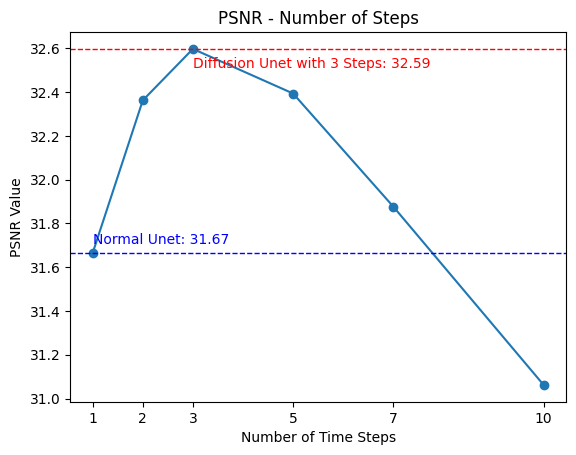

In [79]:
plt.plot(T_values, psnr_values,marker = "o")

plt.title('PSNR - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('PSNR Value')

plt.axhline(y=psnr_values[0], color='b', linestyle='--', linewidth=1)
plt.axhline(y=psnr_values[2], color='r', linestyle='--', linewidth=1)

plt.text(1, psnr_values[0] + 0.03, f'Normal Unet: 31.67', 
         horizontalalignment='left', verticalalignment='bottom', color='b')
plt.text(3, psnr_values[2] - 0.1, f'Diffusion Unet with 3 Steps: 32.59', 
         horizontalalignment='left', verticalalignment='bottom', color='r')

plt.xticks(T_values)

plt.show()

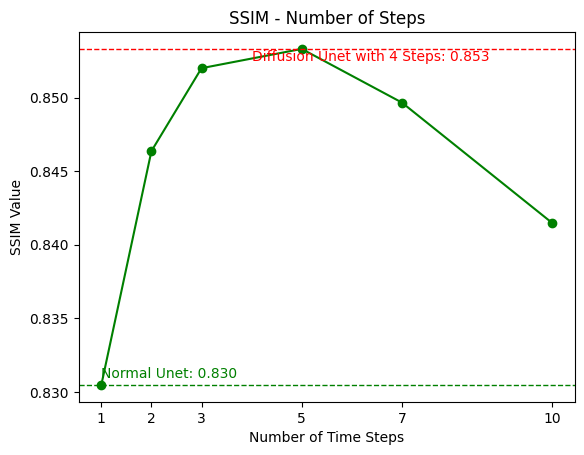

In [19]:
plt.plot(T_values, ssim_values,marker = "o", color = "g")

plt.title('SSIM - Number of Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('SSIM Value')

plt.axhline(y=ssim_values[0], color='g', linestyle='--', linewidth=1)
plt.axhline(y=ssim_values[3], color='r', linestyle='--', linewidth=1)

plt.text(1, ssim_values[0] + 0.0003, f'Normal Unet: 0.830', 
         horizontalalignment='left', verticalalignment='bottom', color='g')
plt.text(4, ssim_values[3] - 0.001, f'Diffusion Unet with 4 Steps: 0.853', 
         horizontalalignment='left', verticalalignment='bottom', color='r')

plt.xticks(T_values)

plt.show()

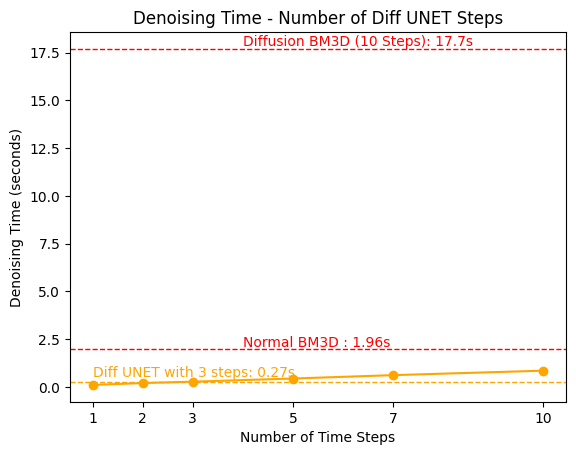

In [43]:
plt.plot(T_values, time_values,marker = "o", color = "orange")

plt.title('Denoising Time - Number of Diff UNET Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('Denoising Time (seconds)')

plt.axhline(y=time_values[2], color='orange', linestyle='--', linewidth=1)
plt.axhline(y=17.7, color='r', linestyle='--', linewidth=1)
plt.axhline(y=1.96, color='r', linestyle='--', linewidth=1)

plt.text(1, time_values[2] + 0.1, f'Diff UNET with 3 steps: 0.27s', 
         horizontalalignment='left', verticalalignment='bottom', color='orange')
plt.text(4, 1.96 - 0.001, f'Normal BM3D : 1.96s', 
         horizontalalignment='left', verticalalignment='bottom', color='r')
plt.text(4, 17.7 - 0.001, f'Diffusion BM3D (10 Steps): 17.7s', 
         horizontalalignment='left', verticalalignment='bottom', color='r')

plt.xticks(T_values)

plt.show()

7


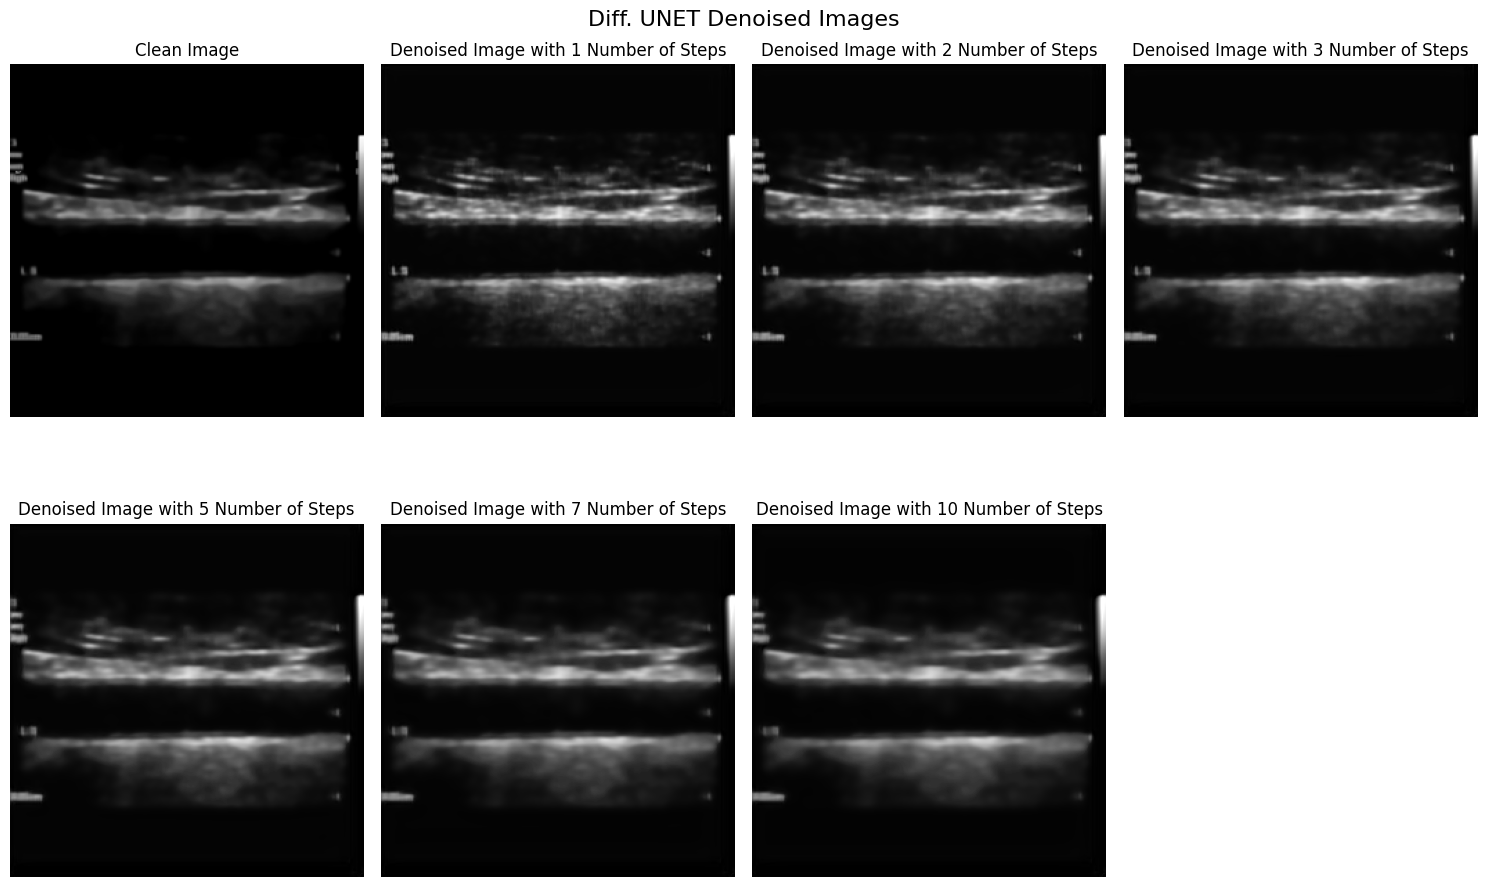

In [51]:
import matplotlib.pyplot as plt

def plot_images(clean_image, images, T_values, title="Diff. UNET Denoised Images"):
    # Insert the clean image at the start of the list
    images.insert(0, clean_image)

    num_images = len(images)
    print(num_images)
    cols = 4
    rows = (num_images + cols - 1) // cols  # Calculate rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(15, 4.5 * rows))
    fig.suptitle(title, fontsize=16)
    
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < num_images:
                axs[i, j].imshow(images[index], cmap='gray')
                axs[i, j].axis('off')  # Hide axes
                if index == 0:
                    axs[i, j].set_title("Clean Image")
                else:
                    axs[i, j].set_title(f"Denoised Image with {T_values[index-1]} Number of Steps")
            else:
                axs[i, j].axis('off')  # Hide axes for empty subplots
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.subplots_adjust(hspace=0.3, top=0.92)  # Adjust top to make room for the title
    plt.show()

# Example usage:


plot_images(clean_images_numpy[4], denoised_images[:6], T_values)

